### Analisi Dati Arpae

In [ ]:
install.packages('dplyr')
library('dplyr')

Installing package into ‘/work/.R/library’
(as ‘lib’ is unspecified)

Warning message in install.packages("dplyr"):
“installation of package ‘dplyr’ had non-zero exit status”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [ ]:
# Clean variables previously defined
rm(list=ls())

# READING DATA ==============================================
# Define the working directory

#setwd("/Data")

# Define the input filenames and assign them to a variable
WinterDataFile <- paste0("Winter", ".txt")

# Read data as a table and assigning to the variable called 'StationData'
Winter_data <- read.table(file(paste0('ARPAE/', WinterDataFile)),
                          fill = TRUE,
                          sep = "", # separate columns by space
                          na.strings = "NA", # tag empty values as "NA"
                          as.is = TRUE, # convert character to factors
                          header = FALSE, # ignore the header
                          skip = 1, # skip the first row
                          col.names = c("Date", "Hour","wndDir",
                                        "wndSpeed") )

SpringDataFile <- paste0("Spring", ".txt")

# Read data as a table and assigning to the variable called 'StationData'
Spring_data <- read.table(file(paste0('ARPAE/', SpringDataFile)),
                          fill = TRUE,
                          sep = "", # separate columns by space
                          na.strings = "NA", # tag empty values as "NA"
                          as.is = TRUE, # convert character to factors
                          header = FALSE, # ignore the header
                          skip = 1, # skip the first row
                          col.names = c("Date", "Hour","wndDir",
                                        "wndSpeed")
                            )

LenSD_W <- dim(Winter_data)[1]
LenSD_S <- dim(Spring_data)[1]

In [ ]:
LenSD_W
LenSD_S

[1] 6507

[1] 6629

In [ ]:
# Dati di 360 settati a 0

Winter_data = Winter_data %>% mutate(wndDir=replace(wndDir, wndDir == 360, 0))
Spring_data = Spring_data %>% mutate(wndDir=replace(wndDir, wndDir == 360, 0))

In [ ]:
NA_filter = function(StationData) {

StationData = dplyr::filter(StationData, StationData$wndSpeed != '' | StationData$wndDir != '' )
return(StationData)}

In [ ]:
DateFormat <- function(StationData) {
# DATE FORMAT ===============================================
# Define 1st and 2nd columns as a String and split into 5 columns
Temp <- t(rbind(as.numeric(substr(StationData[,1],7,10)), # year
          as.numeric(substr(StationData[,1],4,5)), # month
          as.numeric(substr(StationData[,1],1,2)), # day
          as.numeric(substr(StationData[,2],1,2))
          ))

# Define names to rows and columns
colnames(Temp) <- c("Year","Month","Day","Hour")
rownames(Temp) <- 1:dim(Temp)[1]

# Replace the new date format (2 cols > 5 cols) and keep only the WindRose variables
StationData <- cbind(Temp, StationData[,3:4]) 
return(StationData)}

Winter_data = DateFormat(Winter_data)
Spring_data = DateFormat(Spring_data)



In [ ]:
dim(Winter_data)[1]
dim(Spring_data)[1]


[1] 6507

[1] 6629

In [ ]:
# FILTER RECORDS WITH WS<0 ----------------------------------
# Create a variable to storage the excluded values

WSNegFilter <- function(StationData) { 
                                    ExcWSNeg <- dplyr::filter(StationData,(StationData$"wndSpeed" < 0))
                                    StationData <- dplyr::filter(StationData,(StationData$"wndSpeed" >= 0))

                                    LenSD <- dim(StationData)[1]

                                    return(list(data = StationData, time = ExcWSNeg, length = LenSD))}


output = WSNegFilter(Winter_data)
Winter_data = output$data
ExcWSNeg_W = output$time
LenSD_W = c(LenSD_W, output$length)

output = WSNegFilter(Spring_data)
Spring_data = output$data
ExcWSNeg_S = output$time
LenSD_S = c(LenSD_S, output$length)

In [ ]:
# FILTER RECORDS WITH WS > 25 (WMO STANDARD) - CODICE AGGIUNTO

WSstrongFilter2 <- function(StationData) { 
                        ExcWSstrong = 0
                        for (i in 1:dim(StationData)[1]){
                        if((StationData$"wndSpeed" > 25)) ExcWSstrong = c(ExcWSstrong, i)
                        }

                        # Exclude conditioned records from StationData
                        Temp <- ExcWSstrong
                        ExcWSstrong <- StationData[Temp,]
                        StationData <- StationData[-Temp,]

                        # Upload the length of data
                        LenSD <- dim(StationData)[1]
                        
                        return(list(data = StationData, time = ExcWSstrong, length = LenSD))}

WSstrongFilter <- function(StationData) { 
                                    ExcWSstrong <- dplyr::filter(StationData,(StationData$"wndSpeed" >= 25 ))
                                    StationData <- dplyr::filter(StationData,(StationData$"wndSpeed" < 25))

                                    LenSD <- dim(StationData)[1]

                                    return(list(data = StationData, time = ExcWSstrong, length = LenSD))}



output = WSstrongFilter(Winter_data)
Winter_data = output$data
ExcWSstrong_W = output$time
LenSD_W = c(LenSD_W, output$length)

output = WSstrongFilter(Spring_data)
Spring_data = output$data
ExcWSstrong_S = output$time
LenSD_S = c(LenSD_S, output$length)

In [ ]:
# FILTER RECORDS WITH WD<0 ----------------------------------
# Create a variable to storage the excluded values

WDNegFilter <- function(StationData) { 
                                    ExcWDNeg <- dplyr::filter(StationData,(StationData$"wndDir" < 0 | StationData$"wndDir" > 360 ))
                                    StationData <- dplyr::filter(StationData,(StationData$"wndDir" >= 0 & StationData$"wndDir" <= 360 ))

                                    LenSD <- dim(StationData)[1]

                                    return(list(data = StationData, time = ExcWDNeg, length = LenSD))}


output = WDNegFilter(Winter_data)
Winter_data = output$data
ExcWDNeg_W = output$time
LenSD_W = c(LenSD_W, output$length)

output = WDNegFilter(Spring_data)
Spring_data = output$data
ExcWDNeg_S = output$time
LenSD_S = c(LenSD_S, output$length)

In [ ]:
### FUNZIONE FILTRO ###

WConstFilter = function(StationData, hours, value_thresh, par) 

{
a = c()

for (j in hours:dim(StationData)[1]) {
    if (StationData$Hour[j] - StationData$Hour[j - (hours - 1)] == (hours-1))
        {
        for (i in 1:(hours - 1)) {
            if (par == 'speed'){
            diff = abs(StationData$wndSpeed[j] - StationData$wndSpeed[j-i])}
            else if (par == 'direction'){
            diff = abs(StationData$wndDir[j] - StationData$wndDir[j-i])}

            if (diff > value_thresh) {
                break}
            if (i == (hours - 1)) {a = c(a, j - (hours - 1):0)}
            } 
        }           
}

a = sort(a)
a = unique(a)

if (length(a)==0) {
    return(list(data = StationData, time = 0, length=dim(StationData)[1]))
}
else {
return(list(data = StationData[-a,], time = StationData[a,], length=dim(StationData[-a,])[1]))
}
}

output = WConstFilter(Winter_data, 12, 0.5, 'speed')
Winter_data = output$data
ExcWSC12_W = output$time
LenSD_W = c(LenSD_W, output$length)

output = WConstFilter(Spring_data, 12, 0.5, 'speed')
Spring_data = output$data
ExcWSC12_S = output$time
LenSD_S = c(LenSD_S, output$length)


In [ ]:
# FILTER RECORDS WITH WD CONSTANT FOR 3h --------------------

output = WConstFilter(Winter_data, 18, 22.5, 'direction')
Winter_data = output$data
ExcWDC_W = output$time
LenSD_W = c(LenSD_W, output$length)

output = WConstFilter(Spring_data, 18, 22.5, 'direction')
Spring_data = output$data
ExcWDC_S = output$time
LenSD_S = c(LenSD_S, output$length)


In [ ]:
DataConsistency <- function(StationData, LenSD, season) {
            LenSD = LenSD[1:length(LenSD)]
            # Print the Data Consistency Table
            Temp <- c(LenSD[1], min(LenSD), max(LenSD)-min(LenSD),
                        LenSD[1]-LenSD[2], LenSD[2]-LenSD[3], LenSD[3]-LenSD[4], LenSD[4]-LenSD[5],
                        LenSD[5]-LenSD[6])

                        DataCONS <- matrix(as.numeric(c(Temp,round(Temp*100/LenSD[1])),digits=2)
                        ,8,2)

            colnames(DataCONS) <- c(paste0("ARPAE Data"),"(%)")
            rownames(DataCONS) <- c("Available","Valid","Filtered"," > by WSneg"," > by WSstrong", " > by WDNeg", " > by WSC12", " > by WDC")

            print(DataCONS)
            write.table(DataCONS, paste0('ProcessedData/DataCONS_ARPAE_',ifelse(season=='winter', 'winter', 'spring'), '.txt'))
            }

DataConsistency(Winter_data, LenSD_W, 'winter')
DataConsistency(Spring_data, LenSD_S, 'spring')


               ARPAE Data (%)
Available            6507 100
Valid                6296  97
Filtered              211   3
 > by WSneg            11   0
 > by WSstrong          0   0
 > by WDNeg             0   0
 > by WSC12           178   3
 > by WDC              22   0
               ARPAE Data (%)
Available            6629 100
Valid                5163  78
Filtered             1466  22
 > by WSneg          1347  20
 > by WSstrong          0   0
 > by WDNeg             0   0
 > by WSC12            62   1
 > by WDC              57   1


png 
  2

png 
  2

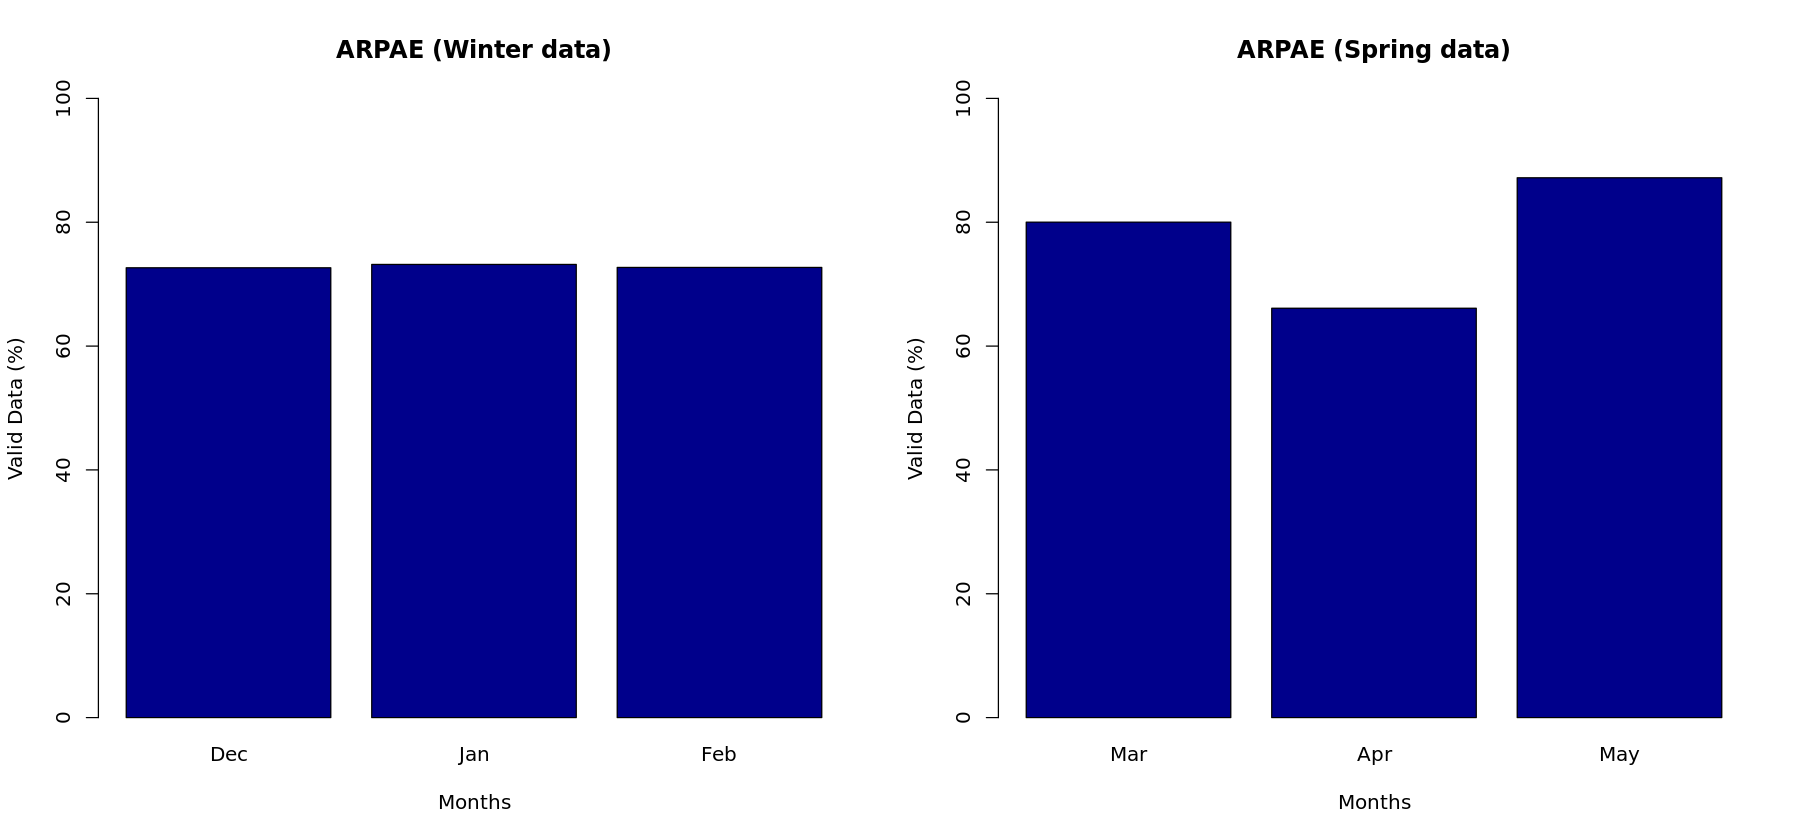

In [ ]:
# Total of Hourly Data Expected by Year (Function)
yexp.data <- function(year) {24*(365 + ifelse((year %% 400)/4 == floor(year %% 400)/4,1,0))}
# Total of Hourly Data Expected by Month (Function)
mexp.data <- function(month) 24*ifelse(month==4|month==6|month==9|month==11,30,
                                        ifelse(month==1|month==3|month==5|month==7|
                                                month==8|month==10|month==12,31,28 ))

PLOT <- function(monthly_perc, data=StationData, season='Winter') {

if (season=='Winter'){
args = c("Dec","Jan","Feb")}
else {
args = c("Mar","Apr","May")
}

barplot(monthly_perc, xlab = "Months", ylab = "Valid Data (%)",
              ylim = c(0,100), col = "darkblue",
              main = paste0("ARPAE", " (",
              ifelse(season == 'Spring', 'Spring data)', 'Winter data)')),
                        names.arg = args)
                        }
                        
                        
ConsistencyBarplot <- function(StationData, season) {

# DISPLAY THE DATA CONSISTENCY BY MONTH AS A BARPLOT ---------
# Compute the percentiles of valid data for each month
monPERC <- function(month, LenSD) {
            100*dim(dplyr::filter(StationData,(StationData$"Month" == month)))[1]/
            (mexp.data(month)*length(unique(StationData$"Year")) +
            sum(ifelse(month == 2 &
                    ((unique(StationData$"Year") %% 400)/4) == floor((unique(StationData$"Year") %% 400)/4),1, 0))) }


iPLOT = c()
if (season == 'Winter') {
for (i in c(12, 1, 2)) {
    iPLOT = c(iPLOT,monPERC(i))}
}
else {
for (i in c(3, 4, 5)) {
    iPLOT = c(iPLOT, monPERC(i))}

}
# Create a function for graphics as barplot

PLOT(iPLOT, StationData, season)


# Save plot as PNG (also accepts PDF, JPG, etc...)
png(file = paste0('Plots/', season ,'_ARPAE_DataConsistency.png'))
PLOT(iPLOT)
dev.off()

}


options(repr.plot.width = 15, repr.plot.height = 7)
par(mfrow=c(1,2))
ConsistencyBarplot(Winter_data, 'Winter')
ConsistencyBarplot(Spring_data, 'Spring')

In [ ]:
LenSD_W[6]/LenSD_W[1]
LenSD_S[6]/LenSD_S[1]

[1] 0.9675734

[1] 0.7788505

In [ ]:
ExportLake <- function(StationData, c= "ciao") {

        StationDataFile <- strsplit("Data/", c,".txt")
        # EXPORT TO LAKE FORMAT ======================================
        toLAKES <- cbind(# Station ID (flag)
                matrix(rep(99999,dim(StationData)[1]),
                dim(StationData)[1],1),
                # Date (year, month, day, hour)
                StationData[,1:4],
                # Rounded Wind Direction (°)
                round(StationData[,5],digits=0),
                # Rounded Wind Speed (knot = 1.94384 x m/s)
                round(1.94384*StationData[,6],digits=0)
                )
        colnames(toLAKES) <- c("StID","YYYY","MM","DD","HH","Dir","WS")
        rownames(toLAKES) <- c(1:dim(StationData)[1])

        write.table(toLAKES, paste0('LAKES/', 'ARPAE', c, "_LAKES.txt"),
        sep = " ", row.names=FALSE, col.names=FALSE)
        }


ExportLake(Winter_data, "winter")
ExportLake(Spring_data, "spring")


In [ ]:
AbsTIME <- function(StationData, i) round(as.numeric(as.Date(paste0(StationData$Year[i], '/',
                            ifelse(StationData$Month[i]<10,"0",""),StationData$Month[i], '/',
                            ifelse(StationData[i,3]<10,"0",""),StationData[i,3] ,"%Y/%m/%d"))
                            + (StationData[i,4]/24), digits=2))
                                                       


# Calculate the absolute time and add to StationData
DataSorter = function(StationData) {
        Temp <- matrix(AbsTIME(StationData, 1:dim(StationData[1])[1]), dim(StationData[1]), 1)
        colnames(Temp) <- c("AbsTime")
        StationData <- cbind(Temp, StationData[,1:6])
        #StationData[1:6,]

        # Sort StationData by the absolute time
        StationData <- StationData[order(StationData$"AbsTime"),]
        rownames(StationData) <- 1:dim(StationData[1])[1]
        return(StationData)

}

Winter_data = DataSorter(Winter_data)
Spring_data = DataSorter(Spring_data)

In [ ]:
#OCCHIO QUA HO MESSO I DATI DI B REINTEGRATI

#Station_B_W <- read.table(file('ProcessedData/B/Winter_B_proc.txt'),
#                          fill = TRUE,
#                          sep = "", # separate columns by space
#                          na.strings = "NA", # tag empty values as "NA"
#                          as.is = TRUE, # convert character to factors
#                          header = FALSE, # ignore the header
#                          skip = 1, # skip the first row
#                          col.names = c("Time", "Year", "Month", "Day", "Hour", "Minutes", "wndSpeed",
#                                        "wndDir") )

Station_B_W <- read.table(file('ProcessedData/B/Winter_proc_B_all.txt'),
                          fill = TRUE,
                          sep = "", # separate columns by space
                          na.strings = "NA", # tag empty values as "NA"
                          as.is = TRUE, # convert character to factors
                          header = FALSE, # ignore the header
                          skip = 1, # skip the first row
                          col.names = c("Year", "Month", "Day", "Hour", "wndSpeed",
                                        "wndDir") )

Station_B_S <- read.table(file('ProcessedData/B/Spring_B_proc.txt'),
                          fill = TRUE,
                          sep = "", # separate columns by space
                          na.strings = "NA", # tag empty values as "NA"
                          as.is = TRUE, # convert character to factors
                          header = FALSE, # ignore the header
                          skip = 1, # skip the first row
                          col.names = c("Time", "Year", "Month", "Day", "Hour", "Minutes", "wndSpeed",
                                        "wndDir") )                                        

In [ ]:
Station_B_W

Year,Month,Day,Hour,wndSpeed,wndDir
<int>,<int>,<int>,<int>,<dbl>,<dbl>
2015,12,1,1,0.894,0.0
2015,12,1,4,0.447,270.0
2015,12,1,5,0.447,292.5
2015,12,1,6,0.447,247.5
2015,12,1,7,0.447,247.5
2015,12,1,8,0.000,225.0
2015,12,1,9,0.894,0.0
2015,12,1,10,1.341,90.0
2015,12,1,23,0.447,0.0


In [ ]:
dim(Winter_data)
dim(Station_B_W)

[1] 6296    7

[1] 6159    6

In [ ]:
EqualData <- function(StationData1, StationData2) { 

                        EqualWS1 = 0
                        EqualWS2 = 0
                        for (i in 1:dim(StationData1)[1]){
                            for( j in 1:dim(StationData2)[1]) {
                            if (StationData1$Time[i] == StationData2$AbsTime[j]) { EqualWS1 = c(EqualWS1, i) 
                            EqualWS2 = c(EqualWS2, j)
                            break}}}

                        
                        StationData1 <- StationData1[EqualWS1,]
                        StationData2 <- StationData2[EqualWS2,]

                        
                        return(list(Station1 = StationData1, Station2 = StationData2))
                        }


In [ ]:
dim(Winter_data)
dim(Station_B_W)

[1] 6296    7

[1] 6159    6

In [ ]:
Winter_data
Station_B_W

,AbsTime,Year,Month,Day,Hour,wndDir,wndSpeed
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,16770,2015,11,30,23,98,0.2
2,16770,2015,12,1,0,221,0.4
3,16770,2015,12,1,1,35,1.0
4,16770,2015,12,1,2,199,1.5
5,16770,2015,12,1,3,232,2.1
6,16770,2015,12,1,4,238,1.5
7,16770,2015,12,1,5,242,0.7
8,16770,2015,12,1,6,51,0.8
9,16770,2015,12,1,7,220,2.3


Year,Month,Day,Hour,wndSpeed,wndDir
<int>,<int>,<int>,<int>,<dbl>,<dbl>
2015,12,1,1,0.894,0.0
2015,12,1,4,0.447,270.0
2015,12,1,5,0.447,292.5
2015,12,1,6,0.447,247.5
2015,12,1,7,0.447,247.5
2015,12,1,8,0.000,225.0
2015,12,1,9,0.894,0.0
2015,12,1,10,1.341,90.0
2015,12,1,23,0.447,0.0


In [ ]:
Station_B_W = dplyr::select(Station_B_W, c('Year', 'Month', 'Day', 'Hour', 'wndSpeed', 'wndDir'))
Winter_data = dplyr::select(Winter_data, c('Year', 'Month', 'Day', 'Hour', 'wndSpeed', 'wndDir'))

Station_B_S = dplyr::select(Station_B_S, c('Year', 'Month', 'Day', 'Hour', 'wndSpeed', 'wndDir'))
Spring_data = dplyr::select(Spring_data, c('Year', 'Month', 'Day', 'Hour', 'wndSpeed', 'wndDir'))

common_data_winter = merge(Winter_data, Station_B_W, by = c('Year', 'Month', 'Day', 'Hour'), suffixes = c('ARPA', 'Station'))
common_data_spring = merge(Spring_data, Station_B_S, by = c('Year', 'Month', 'Day', 'Hour'), suffixes = c('ARPA', 'Station'))

In [ ]:
dim(Station_B_W)
dim(Winter_data)

[1] 6159    6

[1] 6296    6

In [ ]:
dim(Station_B_S)
dim(Spring_data)

[1] 5697    6

[1] 5163    6

In [ ]:
dim(common_data_winter)
dim(common_data_spring)

[1] 5975    8

[1] 4531    8

In [ ]:
common_data_winter %>% filter(wndDirARPA == 360)

Year,Month,Day,Hour,wndSpeedARPA,wndDirARPA,wndSpeedStation,wndDirStation
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


## Scatterplot

In [ ]:
a = lm(common_data_winter$wndSpeedARPA ~ common_data_winter$wndSpeedStation)
intercept = as.character(round(a$coefficients[1], digits = 2))
slope = as.character(round(a$coefficients[2], digits=2))


In [ ]:
intercept

[1] "0.98"

In [ ]:
corr_coef = function(data1, data2) {
    a = sum(( data1 - mean(data1) )*( data2 - mean(data2) ) )/( sqrt(sum((data1 - mean(data1))**2))*sqrt(sum((data2 - mean(data2))**2)) )
    return(a)
}

In [ ]:
sqrt(sum((common_data_winter$wndSpeedStation- mean(common_data_winter$wndSpeedStation))**2))

[1] 65.58782

In [ ]:
corr_coef(common_data_winter$wndSpeedARPA, common_data_winter$wndSpeedStation)

[1] 0.5012554

In [ ]:
pdf('Plots/Correlation_station_ARPA_speed.pdf', width = 25, height = 12.5)

options(repr.plot.width = 25, repr.plot.height = 12.5)
par(mfrow = c(1,2))

a = lm(common_data_winter$wndSpeedARPA ~ common_data_winter$wndSpeedStation)
intercept = as.character(round(a$coefficients[1], digits = 2))
slope = as.character(round(a$coefficients[2], digits=2))
plot(common_data_winter$wndSpeedStation, common_data_winter$wndSpeedARPA,
    xlab = 'Station data', ylab = 'ARPA data', main = 'Correlation plot between station B and ARPA speed data - Winter',
    xlim=c(0,9), ylim=c(0,9), cex.lab = 1.5, cex.main = 2)
lines(seq(-1,10,0.1), seq(-1,10,0.1), col='darkgrey')
abline(lm(common_data_winter$wndSpeedARPA ~ common_data_winter$wndSpeedStation), lwd = 2, col='red')


text(7,2, paste0('y = ', slope,'x + ', intercept), cex = 2, col = 'red')
text(7,1, paste0('r = ', round(corr_coef(common_data_winter$wndSpeedARPA, common_data_winter$wndSpeedStation), digits = 2)), cex = 2)

a = lm(common_data_spring$wndSpeedARPA ~ common_data_spring$wndSpeedStation)
intercept = as.character(round(a$coefficients[1], digits = 2))
slope = as.character(round(a$coefficients[2], digits=2))
plot(common_data_spring$wndSpeedStation, common_data_spring$wndSpeedARPA,
    xlab = 'Station data', ylab = 'ARPA data', main = 'Correlation plot between station B and ARPA speed data - Spring',
    xlim=c(0,9), ylim=c(0,9), cex.lab = 1.5, cex.main = 2)
lines(seq(-1,10,0.1), seq(-1,10,0.1), col='darkgrey')
abline(lm(common_data_spring$wndSpeedARPA ~ common_data_spring$wndSpeedStation), lwd = 2, col='red')


text(7,2, paste0('y = ', slope,'x + ', intercept), cex = 2, col = 'red')
text(7,1, paste0('r = ', round(corr_coef(common_data_spring$wndSpeedARPA, common_data_spring$wndSpeedStation), digits= 2)), cex = 2)
dev.off()

png 
  2

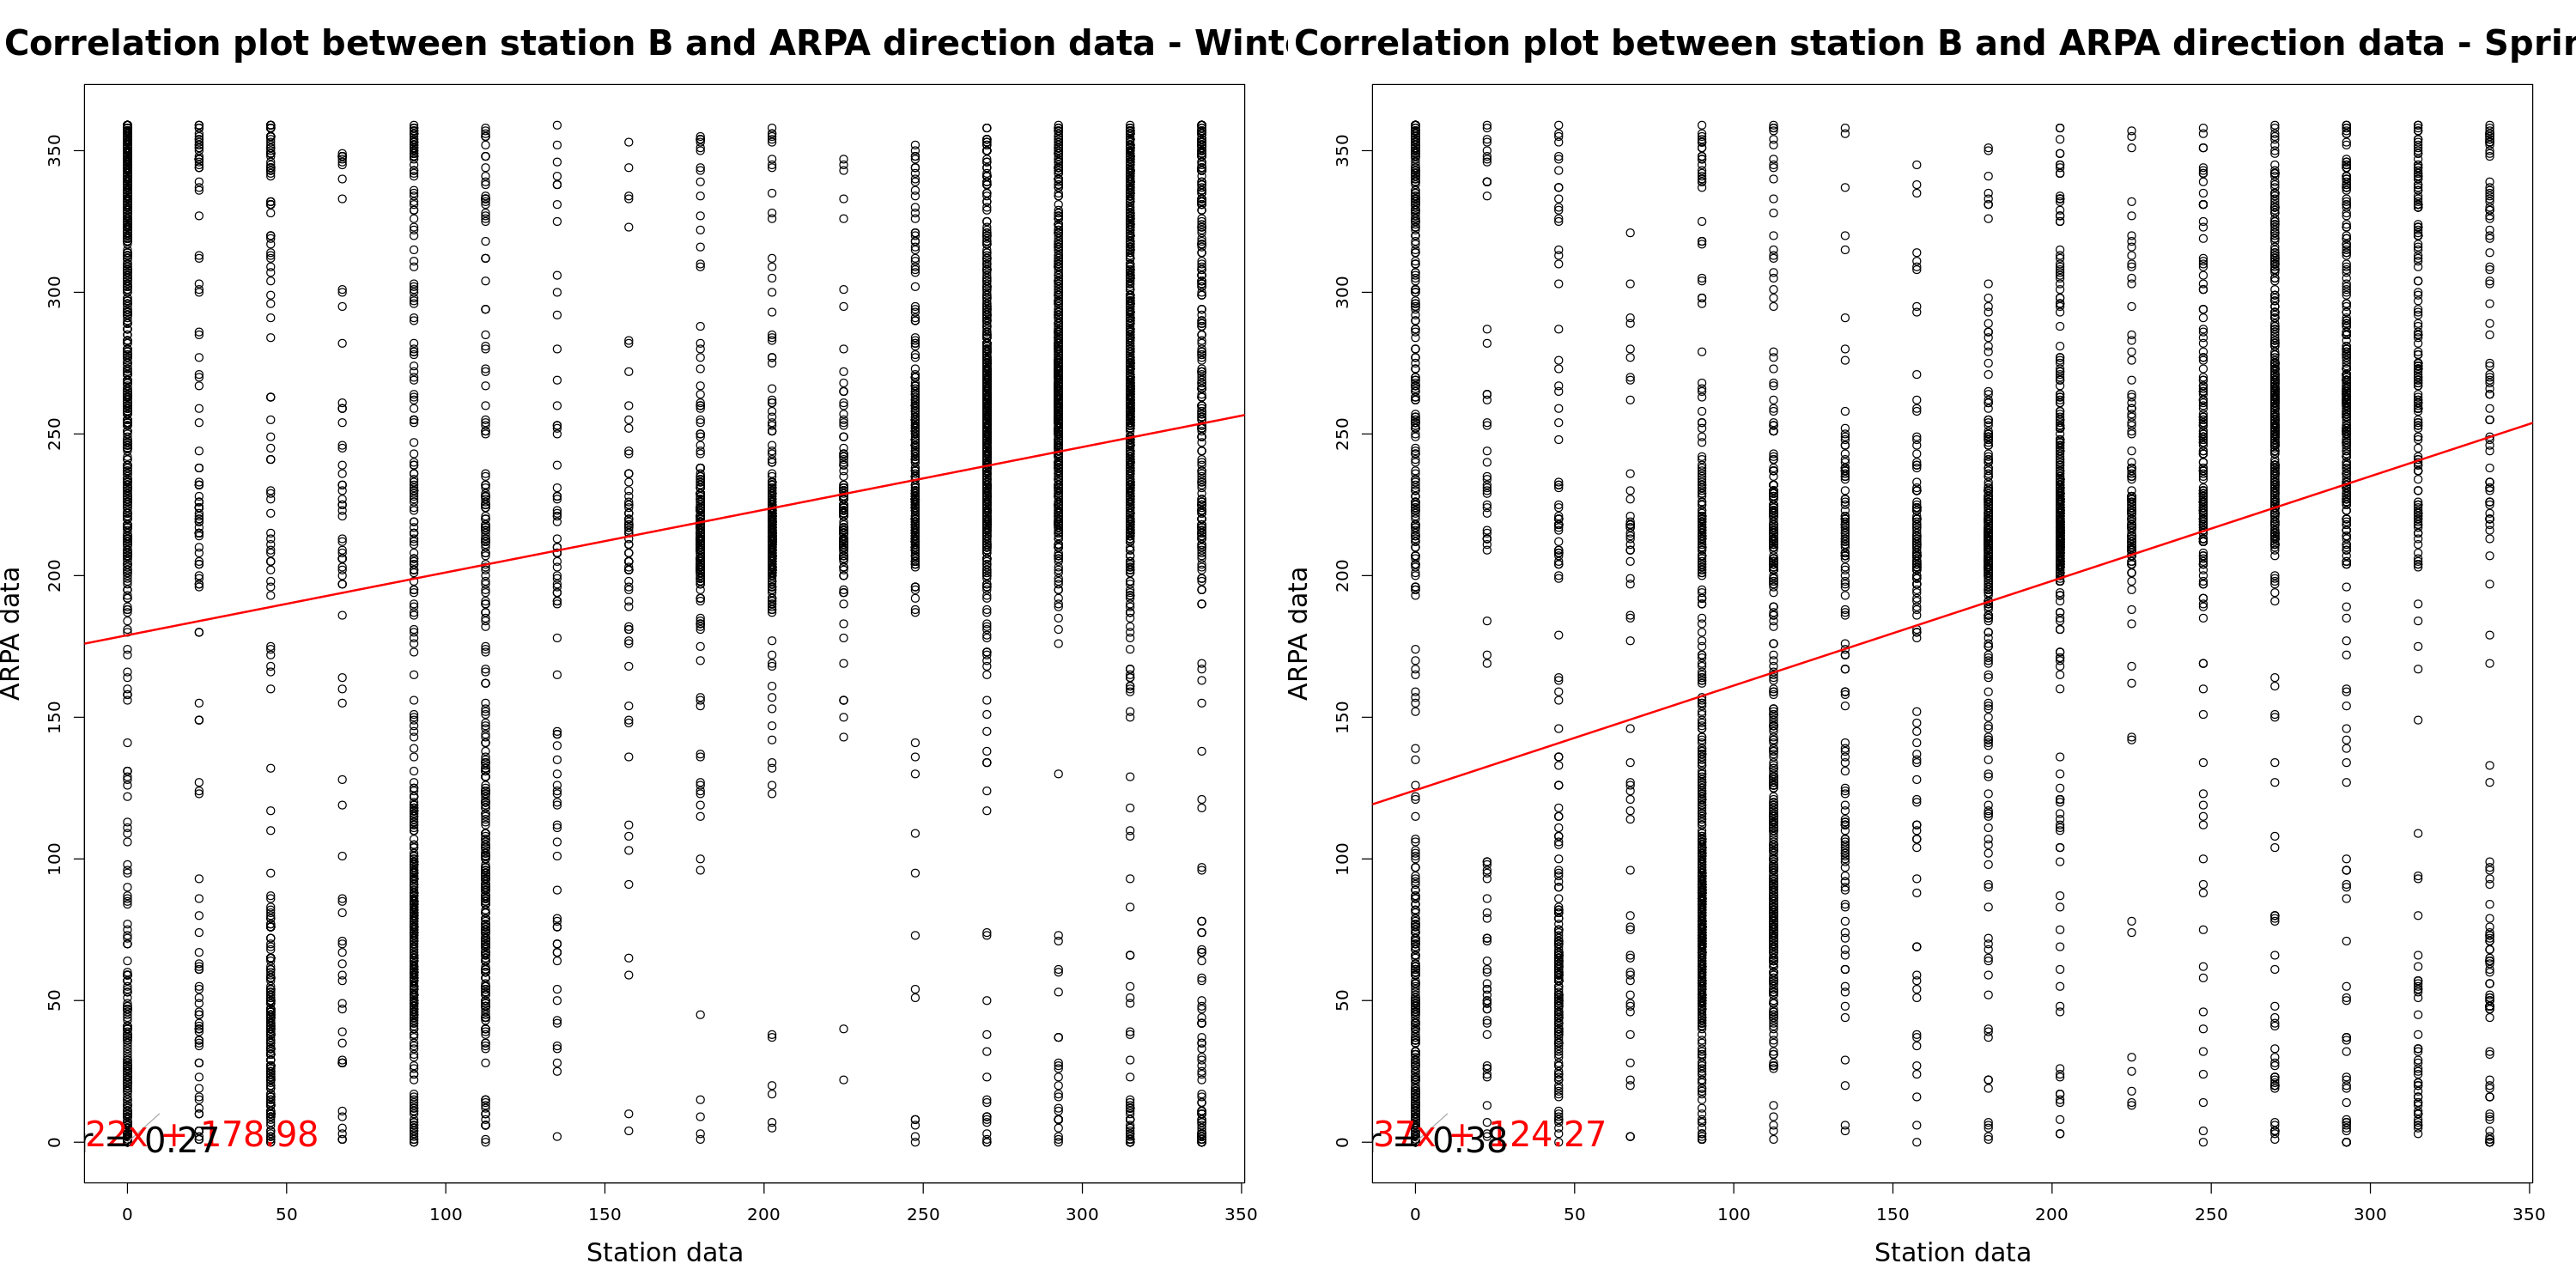

In [ ]:
#pdf('Plots/Correlation_station_ARPA_dir.pdf', width = 25, height = 12.5)

options(repr.plot.width = 25, repr.plot.height = 12.5)
par(mfrow = c(1,2))

a = lm(common_data_winter$wndDirARPA ~ common_data_winter$wndDirStation)
intercept = as.character(round(a$coefficients[1], digits = 2))
slope = as.character(round(a$coefficients[2], digits=2))
plot(common_data_winter$wndDirStation, common_data_winter$wndDirARPA,
    xlab = 'Station data', ylab = 'ARPA data', main = 'Correlation plot between station B and ARPA direction data - Winter',
    #xlim=c(0,9), ylim=c(0,9), 
    cex.lab = 1.5, cex.main = 2)
lines(seq(-1,10,0.1), seq(-1,10,0.1), col='darkgrey')

abline(lm(common_data_winter$wndDirARPA ~ common_data_winter$wndDirStation), lwd = 2, col='red')


text(7,2, paste0('y = ', slope,'x + ', intercept), cex = 2, col = 'red')
text(7,1, paste0('r = ', round(corr_coef(common_data_winter$wndDirARPA, common_data_winter$wndDirStation), digits = 2)), cex = 2)

a = lm(common_data_spring$wndDirARPA ~ common_data_spring$wndDirStation)
intercept = as.character(round(a$coefficients[1], digits = 2))
slope = as.character(round(a$coefficients[2], digits=2))
plot(common_data_spring$wndDirStation, common_data_spring$wndDirARPA,
    xlab = 'Station data', ylab = 'ARPA data', main = 'Correlation plot between station B and ARPA direction data - Spring',
    #xlim=c(0,9), ylim=c(0,9), 
    cex.lab = 1.5, cex.main = 2)
lines(seq(-1,10,0.1), seq(-1,10,0.1), col='darkgrey')
abline(lm(common_data_spring$wndDirARPA ~ common_data_spring$wndDirStation), lwd = 2, col='red')


text(7,2, paste0('y = ', slope,'x + ', intercept), cex = 2, col = 'red')
text(7,1, paste0('r = ', round(corr_coef(common_data_spring$wndDirARPA, common_data_spring$wndDirStation), digits= 2)), cex = 2)
#dev.off()

In [ ]:
# si potrebbe fare un'analisi aggiuntiva e riscalare i dati arpa
# alla risoluzione di quelli della stazione

## Confronto velocità - direzione ciclo diurno tra dati comuni

In [ ]:
library('ggplot2')

In [ ]:
data_w_st = common_data_winter %>% select('Year', 'Month', 'Day', 'Hour', 'wndSpeedStation', 'wndDirStation')
data_w_arpa = common_data_winter %>% select('Year', 'Month', 'Day', 'Hour', 'wndSpeedARPA', 'wndDirARPA')

data_s_st = common_data_spring %>% select('Year', 'Month', 'Day', 'Hour', 'wndSpeedStation', 'wndDirStation')
data_s_arpa = common_data_spring %>% select('Year', 'Month', 'Day', 'Hour', 'wndSpeedARPA', 'wndDirARPA')

In [ ]:
hourly_mean_w_st = data_w_st %>% 
                    group_by(Hour, wndDirStation) %>% 
                    summarise(counts = n()) #%>%
                    #group_by(Hour) %>% 
                    #summarise(maxCounts = max(counts), dirMean = wndDirStation[which.max(counts)]) %>%
                    #merge(data_w_st %>% group_by(Hour) %>% summarise(spdMean = mean(wndSpeedStation)))

`summarise()` has grouped output by 'Hour'. You can override using the `.groups` argument.



In [ ]:
hourly_mean_w_st

Hour,wndDirStation,counts
<dbl>,<dbl>,<int>
0,0.0,20
0,22.5,5
0,45.0,10
0,67.5,1
0,90.0,10
0,112.5,14
0,135.0,3
0,157.5,5
0,180.0,19


Warning message:
“Unknown or uninitialised column: `spdMean`.”
Warning message:
“Unknown or uninitialised column: `dirMean`.”


ERROR: Error in cos(hourly_mean_w_st$dirMean): non-numeric argument to mathematical function


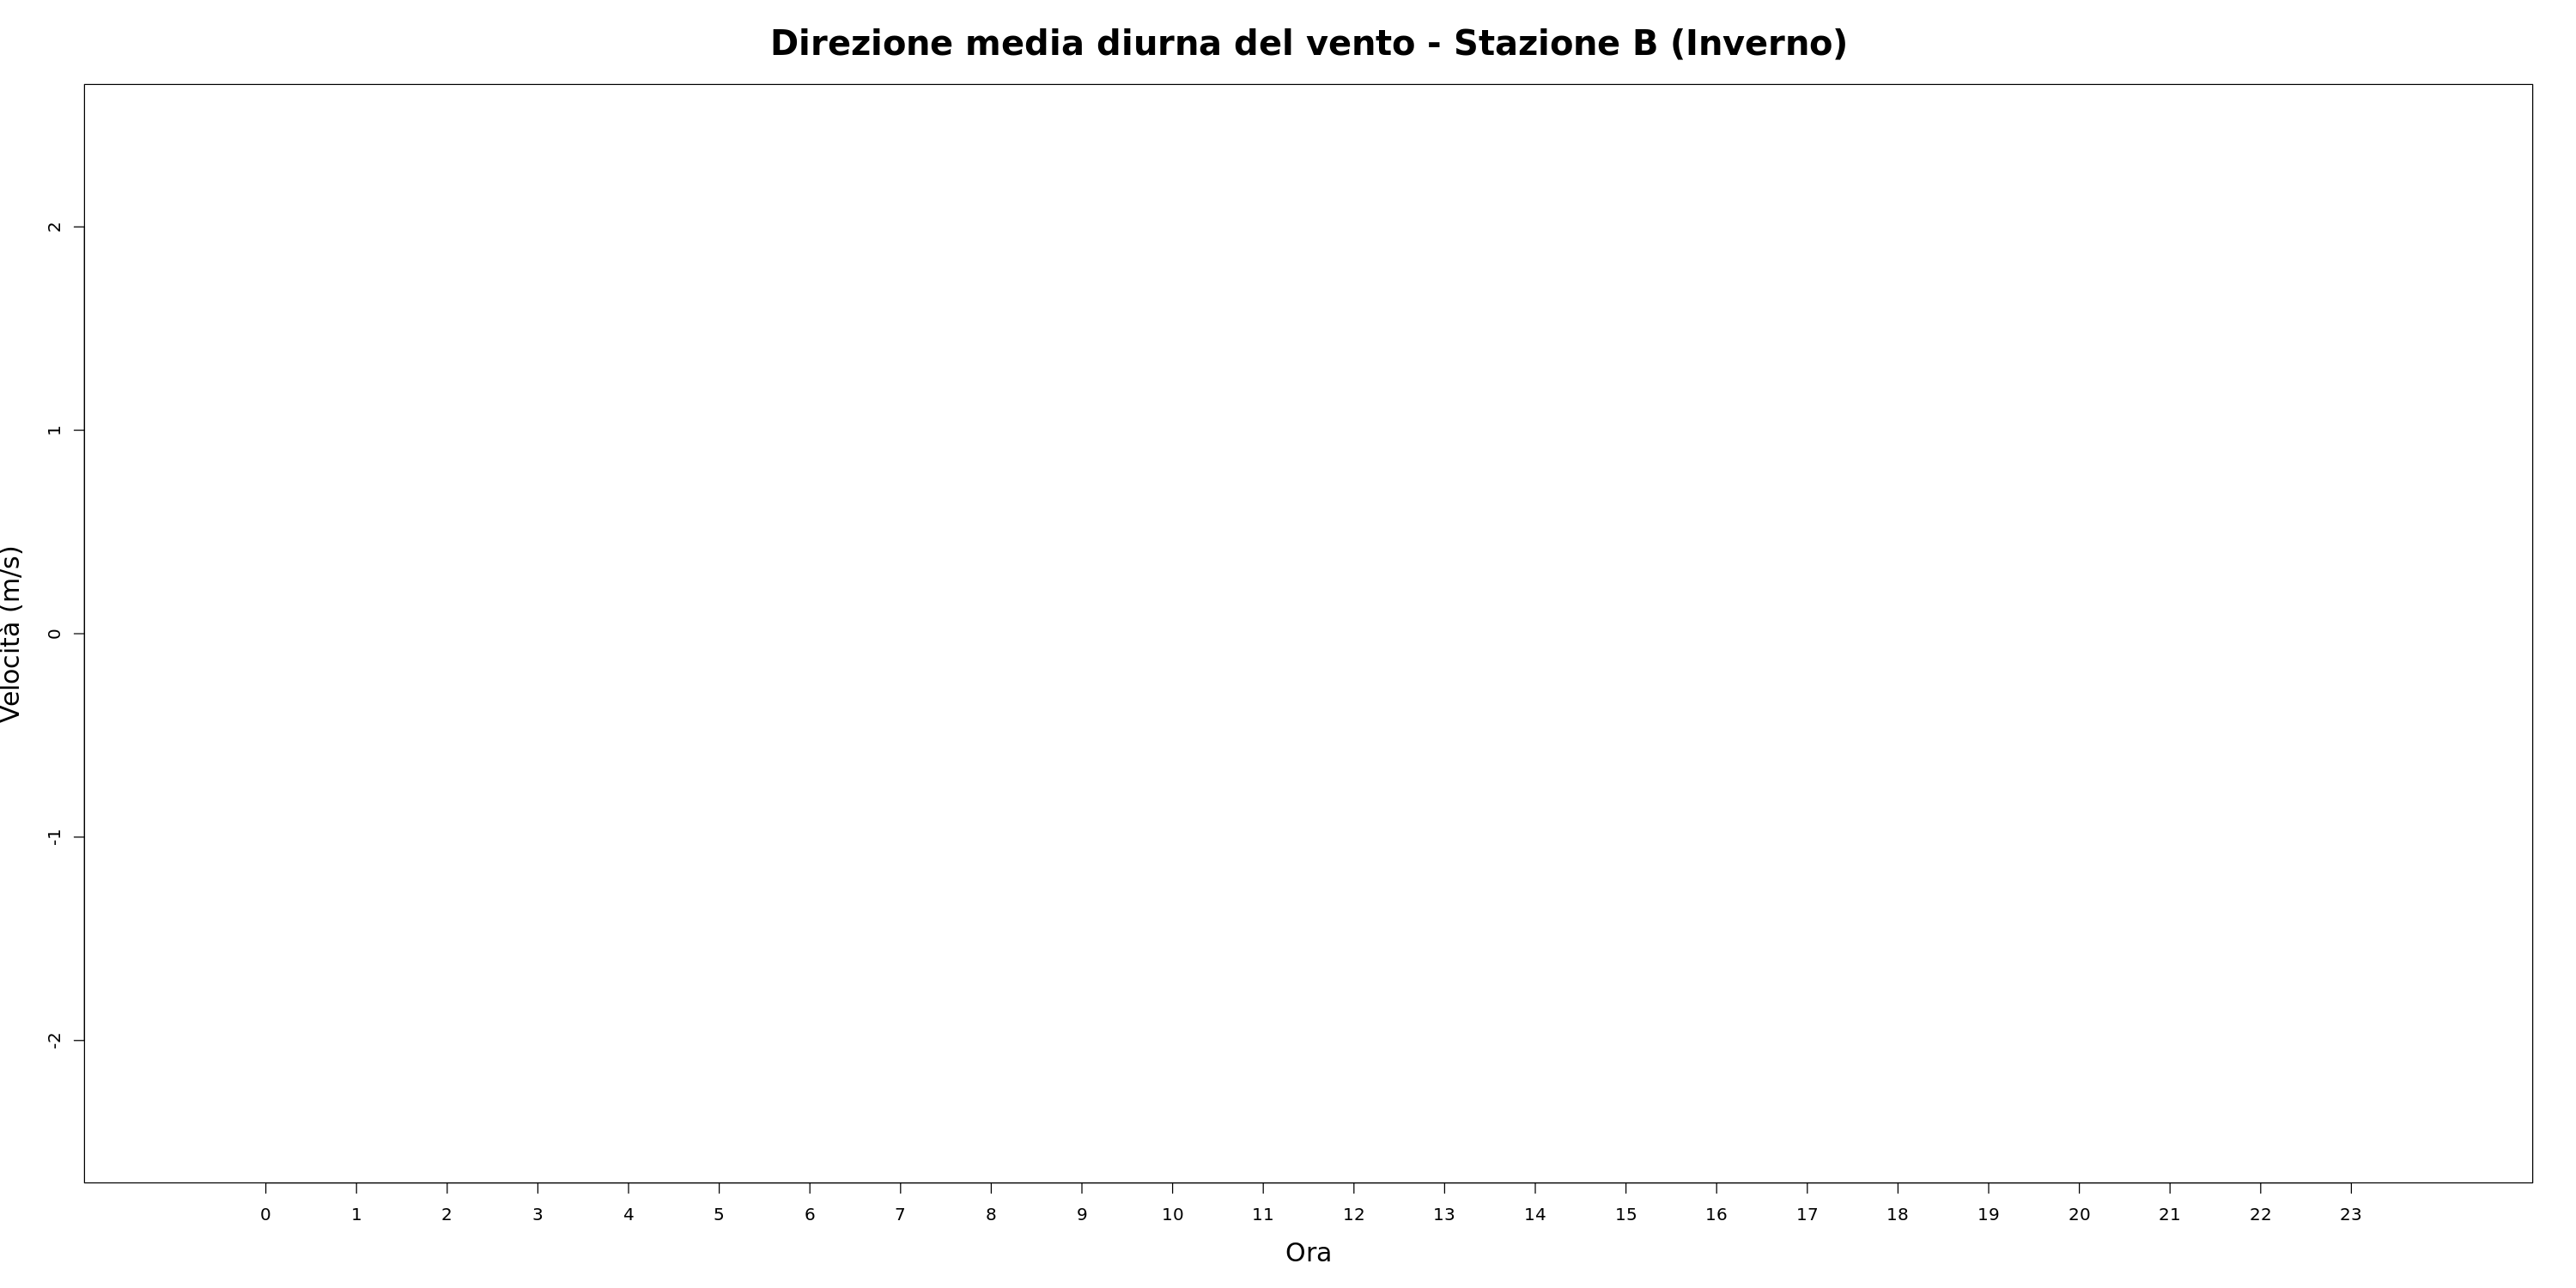

In [ ]:
plot(0:23, rep(0,24), type = 'n', ylim = c(-2.5,2.5), main = 'Direzione media diurna del vento - Stazione B (Inverno)', cex.main = 2,
    ylab = 'Velocità (m/s)', xlab = 'Ora', xlim = c(-1,24), xaxt = 'n', cex.lab = 1.5,
    col = 'blue')
axis(1, at = 0:23)
arrows(0:23, rep(0,24), 0:23 + hourly_mean_w_st$spdMean*cos(hourly_mean_w_st$dirMean), 
            hourly_mean_w_st$spdMean*sin(hourly_mean_w_st$dirMean), lwd=2,
        col = 'blue')

In [ ]:
hourly_mean_w_st = data_w_st %>% dplyr::group_by(Hour) %>% dplyr::summarise(spdMean = mean(wndSpeedStation), dirMean = mean(wndDirStation)*pi/180, spdStd = sd(wndSpeedStation))
hourly_mean_w_arpa = data_w_arpa %>% dplyr::group_by(Hour) %>% dplyr::summarise(spdMean = mean(wndSpeedARPA), dirMean = mean(wndDirARPA)*pi/180, spdStd = sd(wndSpeedARPA))

hourly_mean_s_st = data_s_st %>% dplyr::group_by(Hour) %>% dplyr::summarise(spdMean = mean(wndSpeedStation), dirMean = mean(wndDirStation)*pi/180, spdStd = sd(wndSpeedStation))
hourly_mean_s_arpa = data_s_arpa %>% dplyr::group_by(Hour) %>% dplyr::summarise(spdMean = mean(wndSpeedARPA), dirMean = mean(wndDirARPA)*pi/180, spdStd = sd(wndSpeedARPA))

In [ ]:
a = hourly_mean_s_arpa$spdMean
hourly_mean_s_arpa$spdMean[3:24] = a[1:22]
hourly_mean_s_arpa$spdMean[1:3] = a[22:24]

a = hourly_mean_w_arpa$spdMean
hourly_mean_w_arpa$spdMean[2:24] = a[1:23]
hourly_mean_w_arpa$spdMean[1:2] = a[23:24]

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 14)
pdf('Plots/ciclo_diurno_dir_inv.pdf', width = 15, height = 14)
par(mfrow = c(2,1))


plot(0:23, rep(0,24), type = 'n', ylim = c(-2.5,2.5), main = 'Direzione media diurna del vento - Stazione B (Inverno)', cex.main = 2,
    ylab = 'Velocità (m/s)', xlab = 'Ora', xlim = c(-1,24), xaxt = 'n', cex.lab = 1.5,
    col = 'blue')
axis(1, at = 0:23)
arrows(0:23, rep(0,24), 0:23 + hourly_mean_w_st$spdMean*cos(hourly_mean_w_st$dirMean), 
        hourly_mean_w_st$spdMean*sin(hourly_mean_w_st$dirMean), lwd=2,
        col = 'blue')

plot(0:23, rep(0,24), type = 'n', ylim = c(-2.5,2.5), main = 'Direzione media diurna del vento - Dati ARPA (Inverno)', cex.main = 2,
    ylab = 'Velocità (m/s)', xlab = 'Ora', xlim = c(-1,24), xaxt = 'n', cex.lab = 1.5, col = 'red')
axis(1, at = 0:23)
arrows(0:23, rep(0,24), 0:23 + hourly_mean_w_arpa$spdMean*cos(hourly_mean_w_arpa$dirMean), 
        hourly_mean_w_arpa$spdMean*sin(hourly_mean_w_arpa$dirMean), lwd = 2, col = 'red')

dev.off()

png 
  2

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 14)

pdf('Plots/ciclo_diurno_dir_prim.pdf', width = 15, height = 14)
par(mfrow = c(2,1))

plot(0:23, rep(0,24), type = 'n', ylim = c(-2.5,2.5), main = 'Direzione media diurna del vento - Stazione B (Primavera)', cex.main = 2,
    ylab = 'Velocità (m/s)', xlab = 'Ora', xlim = c(-1,24), xaxt = 'n',
    cex.lab = 1.5, col = 'blue')
axis(1, at = 0:23)
arrows(0:23, rep(0,24), 0:23 + hourly_mean_s_st$spdMean*cos(hourly_mean_s_st$dirMean), 
        hourly_mean_s_st$spdMean*sin(hourly_mean_s_st$dirMean), lwd=2, col = 'blue')

plot(0:23, rep(0,24), type = 'n', ylim = c(-2.5,2.5), main = 'Direzione media diurna del vento - Dati ARPA (Primavera)', cex.main = 2,
    ylab = 'Velocità (m/s)', xlab = 'Ora', xlim = c(-1,24), xaxt = 'n',
    cex.lab = 1.5, col = 'red')
axis(1, at = 0:23)
arrows(0:23, rep(0,24), 0:23 + hourly_mean_s_arpa$spdMean*cos(hourly_mean_s_arpa$dirMean), 
        hourly_mean_s_arpa$spdMean*sin(hourly_mean_s_arpa$dirMean), lwd = 2, col = 'red')

dev.off()

png 
  2

In [ ]:
# INVERNO
options(repr.plot.width = 20, repr.plot.height = 15)
pdf('Plots/velocità_medie_diurne.pdf', width = 20, height = 15)
par(mfrow = c(2,1))

plot(0:23, hourly_mean_w_arpa$spdMean, ylim = c(0,4), type = 'b',
    col = 'red', xlab = 'Ora', ylab = 'Velocità (m/s)', lwd=2, main = 'Velocità media diurna - Inverno',
    cex.main = 2.5, cex.lab = 2)
lines(0:23, hourly_mean_w_st$spdMean, lwd=2, type = 'b', col = 'blue')
legend(17,4.2, col = c('red', 'blue'), lwd = 2, legend = c('Dati ARPA', 'Stazione B'), bty = 'n', cex = 2.5, y.intersp = 0.9, x.intersp = 0.5)


plot(0:23, hourly_mean_s_arpa$spdMean, ylim = c(0,4), type = 'b',
    col = 'red', xlab = 'Ora', ylab = 'Velocità (m/s)', lwd = 2, main = 'Velocità media diurna - Primavera',
    cex.main = 2.5, cex.lab = 2)
lines(0:23, hourly_mean_s_st$spdMean, lwd=2, type = 'b', col = 'blue')
legend(17,4.2, col = c('red', 'blue'), lwd = 2, legend = c('Dati ARPA', 'Stazione B'), bty = 'n', cex = 2.5, y.intersp = 0.9, x.intersp = 0.5)
dev.off()


png 
  2

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 7)
pdf('Plots/velocità_medie_diurne.pdf', width = 20, height = 7)
par(mfrow=c(1,2))
plot(0:23, hourly_mean_w_st$spdMean, pch = 20, type = 'b',
    main = 'Ciclo diurno velocità del vento - Inverno', cex.main = 1.7,
    xlab = 'Ora', ylab = 'Velocità (m/s)', cex.lab = 1.5,
    cex.axis = 1, col = '#045a8d', lwd = 2, ylim = c(0,4),
    xaxt = 'n')
axis(1, at = 0:23, cex = 0.7)
polygon(c(0:23, 23:0), c(hourly_mean_w_st$spdMean - hourly_mean_w_st$spdStd, hourly_mean_w_st$spdMean[24:1] + hourly_mean_w_st$spdStd[24:1]),
        col = 'lightblue', density = 25)
lines(0:23, hourly_mean_w_arpa$spdMean, lwd = 2, type = 'b', col = '#74a9cf')
legend('top', bty = 'n', legend = c('Stazione B', 'Dati ARPAE'),
    col = c('#045a8d', '#74a9cf'), lwd = 2)


plot(0:23, hourly_mean_s_st$spdMean, 
    col = '#c51b8a',
    pch = 20, type = 'b',
    main = 'Ciclo diurno velocità del vento - Primavera', cex.main = 1.7,
    xlab = 'Ora', ylab = 'Velocità (m/s)', cex.lab = 1.5,
    cex.axis = 1, lwd = 2, ylim = c(0,4),
    xaxt = 'n')
axis(1, at = 0:23, cex = 0.7)
polygon(c(0:23, 23:0), c(hourly_mean_s_st$spdMean - hourly_mean_s_st$spdStd, hourly_mean_s_st$spdMean[24:1] + hourly_mean_s_st$spdStd[24:1]),
        col = 'pink', density = 25)
lines(0:23, hourly_mean_s_arpa$spdMean, lwd = 2, type = 'b', col = '#fbb4b9')
legend('top', bty = 'n', legend = c('Stazione B', 'Dati ARPAE'),
    col = c('#c51b8a', '#fbb4b9'), lwd = 2)
dev.off()


png 
  2

In [ ]:
h = c()
mean = c()
c1 = c()
c2 = c()

for (i in 1:24) {
    hourly = data_w_arpa %>% filter(Hour == i - 1) %>% select(wndSpeedARPA)
    h = c(h, i - 1)
    mean = c(mean, max(density(hourly$wndSpeedARPA)$y))
    c1 = c(c1, quantile(density(hourly$wndSpeedARPA)$y, 0.025))
    c2 = c(c2, quantile(density(hourly$wndSpeedARPA)$y, 0.975))
}

In [ ]:
c2

97.5%     97.5%     97.5%     97.5%     97.5%     97.5%     97.5%     97.5% 
0.3133638 0.3043935 0.3138015 0.3444288 0.3201607 0.3272380 0.3575162 0.3579379 
    97.5%     97.5%     97.5%     97.5%     97.5%     97.5%     97.5%     97.5% 
0.3896486 0.4197449 0.4962775 0.5487325 0.5445968 0.5896872 0.5404346 0.4811287 
    97.5%     97.5%     97.5%     97.5%     97.5%     97.5%     97.5%     97.5% 
0.4159338 0.4280391 0.4753731 0.4406328 0.3568274 0.3573791 0.3550450 0.3017754

In [ ]:
quantile(density(hourly$wndSpeedARPA), 0.25)

ERROR: Error in rank(x, ties.method = "min", na.last = "keep"): unimplemented type 'list' in 'greater'



In [ ]:
quantile(density(hourly$wndSpeedARPA)$y, 0.25)

25% 
0.01082219

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a65805a3-5683-44f7-87a1-3d0b16d3432c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>